In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append(r"C:\Users\TCSPC\Documents\GitHub\pyTCSPC")

import pyTCSPC as pc

import multipletau as mt

from glob import glob
from pathlib import Path, PurePath

import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage as ndi
from scipy.optimize import curve_fit

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_otsu

from tqdm.notebook import tqdm, trange

import xarray as xr

C:\Users\TCSPC\Documents\GitHub\pyTCSPC\pyTCSPC\spc.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [109]:
%cd C:\Users\TCSPC\Desktop\fov10

C:\Users\TCSPC\Desktop\fov10


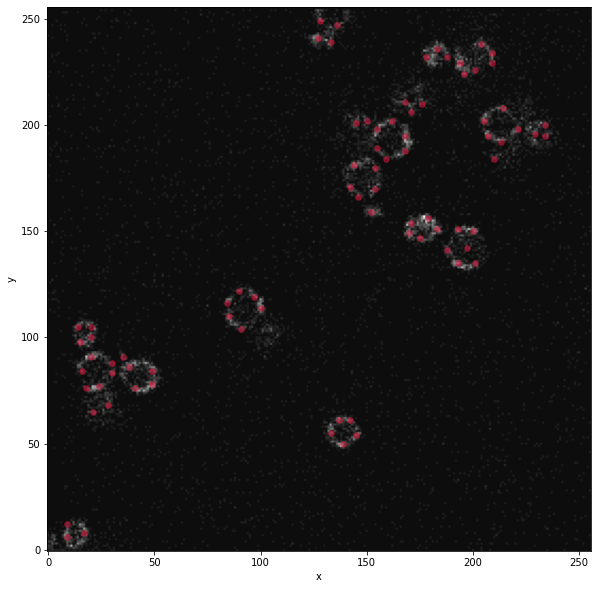

In [110]:
sdt = pc.load_sdt("img.sdt").isel(file_info=0).sel(channel="M1")

zoom = 8
nx = len(sdt.x)
ny = len(sdt.y)

im = pc.intensity_image(sdt.compute())
# im.data = np.flip(im.data, axis=0)
# plt.figure(figsize=(10,10))
# plt.imshow(im, alpha=0.5, cmap="Reds")
im = im.data

im_binary = im > threshold_otsu(im)
im_binary = remove_small_objects(im_binary, 6)
distance = ndi.distance_transform_edt(im_binary)
coords = peak_local_max(distance, footprint=np.ones((5, 5)), min_distance=5)
y, x = tuple(coords[:].T)

sx = ((x-(nx//2))/(nx//2))*(100/zoom)
sy = ((y-(ny//2))/(ny//2))*(100/zoom)
np.savetxt("points.dat", np.vstack([sx, sy]).T, fmt='%2.4f')

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im, cmap="gray", alpha=0.95)
plt.gca().invert_yaxis()

plt.scatter(x, y, s=30, c="crimson", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y");

In [111]:
len(coords)

81

  0%|          | 0/88 [00:00<?, ?it/s]

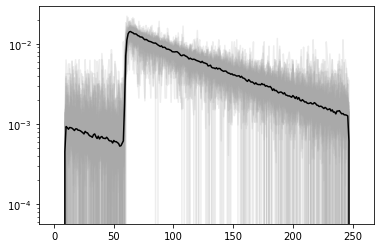

In [104]:
fns = glob("*.spc")

adc = 16
maxtime = 1

bin_centers = np.arange(4096/adc)
bins = np.arange(1+4096/adc)-0.5
combined_hist = np.zeros_like(bin_centers)

i = 0
for fn in tqdm(fns[:]):
    spc = pc.SPC(fn, pixels_per_line=1, nlines=1, n_lines_skip=0, read_paired_sdt=False, show_progress=False, save_images=False)

    hist, _ = np.histogram(spc.all_photons.sel(time=slice(0, maxtime))["microtime"].data/adc, bins=bins);
    combined_hist += hist
    
    plt.plot(bin_centers, hist/np.sum(hist), color="darkgray", alpha=0.2)
    
    i += 1
    # if i > 10:
    #     break
    
plt.plot(bin_centers, combined_hist/np.sum(combined_hist), color="k", alpha=1)
plt.yscale("log")

# calculate correlation functions

  0%|          | 0/88 [00:00<?, ?it/s]

(array([15.8844813 ,  3.87577456, -0.03533764]),
 array([[2.98862518e+03, 1.72152875e+02, 2.26748047e-01],
        [1.72152875e+02, 1.00587403e+01, 1.50870239e-02],
        [2.26748047e-01, 1.50870239e-02, 4.12834845e-04]]),
 0.258012942669836)

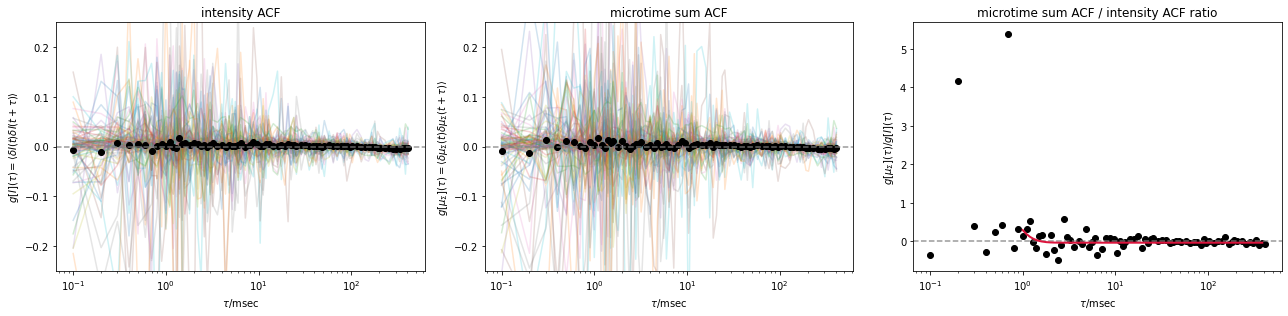

In [105]:
maxtime = 0.5
tunit = 1e3 # time unit, relative to seconds (e.g. 1e3 --> 1e-3 sec = 1 msec)
dt = 10e-5 * tunit
norm_behv = True

fig, ax = plt.subplots(figsize=(18,4.5), ncols=3)

avg_sumtau_acf = None
avg_int_acf = None

for i in tqdm(np.arange(0,len(fns))):

    for j in [0,]: #range(3):
        all_photons = xr.load_dataset(
            Path(fns[i]).with_suffix(".nc")
        ).sel(time=slice(j*maxtime, (j+1)*maxtime))

        # macrotimes, now in msec
        times = tunit * all_photons["time"].data
        bin_edges = np.arange(0,np.max(times),dt)

        counts, bin_edges = np.histogram(times, bins=bin_edges, weights=all_photons["microtime"])
        lag_time, sumtau_acf = tuple(mt.autocorrelate(counts.astype(float), normalize=norm_behv, deltat=dt).T)
        if avg_sumtau_acf is None: avg_sumtau_acf  = sumtau_acf
        else:                      avg_sumtau_acf += sumtau_acf

        counts, bin_edges = np.histogram(times, bins=bin_edges)
        lag_time, int_acf = tuple(mt.autocorrelate(counts.astype(float), normalize=norm_behv, deltat=dt).T)
        if avg_int_acf is None: avg_int_acf  = int_acf
        else:                   avg_int_acf += int_acf

        ax[0].plot(lag_time[1:], int_acf[1:], alpha=0.2)
        ax[1].plot(lag_time[1:], sumtau_acf[1:], alpha=0.2)
    
mean_racf = ((avg_sumtau_acf+1)/(avg_int_acf+1))-1

istartlag, iendlag = 1, None
ax[0].plot(lag_time[istartlag:iendlag], avg_int_acf[istartlag:iendlag]/len(fns), "o", color="k")
ax[1].plot(lag_time[istartlag:iendlag], avg_sumtau_acf[istartlag:iendlag]/len(fns), "o", color="k")
ax[2].plot(lag_time[istartlag:iendlag], mean_racf[istartlag:iendlag], "o", color="k")
    

for i in [0,1,2]:
    ax[i].axhline(y=0, color="gray", alpha=0.8, linestyle="--")
    ax[i].set_xlabel(r"$\tau$/msec")
    ax[i].set_xscale("log")
ax[0].set_ylabel(r"$g\left[ I \right] (\tau) = \langle \delta I(t) \delta I (t+\tau) \rangle$")
ax[1].set_ylabel(r"$g\left[ \mu_{\Sigma} \right] (\tau) = \langle \delta \mu_{\Sigma} (t) \delta \mu_{\Sigma} (t+\tau) \rangle$")
ax[2].set_ylabel(r"$g\left[ \mu_{\Sigma} \right] (\tau) / g \left[ I \right] (\tau)$")
ax[0].set_title(r"intensity ACF")
ax[1].set_title(r"microtime sum ACF")
ax[2].set_title(r"microtime sum ACF / intensity ACF ratio")
plt.tight_layout()

istartlag, iendlag = 10, -1
def func(x, a, c, d):
    return a*np.exp(-c*x) + d
popt, pcov = curve_fit(func, lag_time[istartlag:iendlag], mean_racf[istartlag:iendlag], sigma=np.sqrt(mean_racf[istartlag:iendlag]+1), p0=(0.25, 1/3e0, 0))
yy = func(lag_time, *popt)
ax[2].plot(lag_time[istartlag:iendlag], yy[istartlag:iendlag], color="crimson", lw=2)
for i in range(2):
    ax[i].set_ylim([-0.25,0.25])
# ax[2].set_ylim([-0.5,1.5])
# plt.savefig(f"cell{cellnum:d}.png", dpi=300, bbox_inches="tight")
popt, pcov, popt[1]**-1

# FLIM

### load irf

In [ ]:
irf = pc.load_sdt(r"C:\Users\TCSPC\Documents\2022-07-05 PercevalHR, yEA78, 79, and yEA92 +- CHI\calibration/IRF.sdt", dims="CXM", dtype=np.uint32).compute()
fig, ax = plt.subplots(figsize=(12,4))
dc_kwargs_M1 = {
    "trunc": True,
    "peak_start": 2.6,
    "peak_end": 3.85,
    # "bgsub": True,
    "bg_start": 8,
    "bg_end": 10,
    "fig": fig,
    "ax": ax
}
dc_kwargs_M2 = {
    "trunc": True,
    "peak_start": 2.25,
    "peak_end": 3.5,
    # "bgsub": True,
    "bg_start": 8,
    "bg_end": 10,
    "fig": fig,
    "ax": ax
}
fig, ax, dc = pc.decay_curve(irf.sel(channel="M1"), plot=True, **dc_kwargs_M1)
plt.yscale("log")

irf

### fit

In [ ]:
dg = pc.decay_group(
    combined_hist,
    irf.sel(channel="M1"),
    irf_kws=dc_kwargs_M2,
    fit_start_bin=10,
    fit_end_bin=235
)
fitp, status = dg.fit(
    model="1exp",
    fixed_parameters=[],
    save_leastsq_params_array=True,
    verbose=False,
    plot=True
)
fitp

In [ ]:
fitp, status = dg.fit(
    model="2exp",
    fixed_parameters=[],
    save_leastsq_params_array=True,
    verbose=False,
    plot=True
)
fitp